# MoS2 SR3 Diffusion (Data prep → Training → Visualization)

End-to-end notebook for the hackathon. It prepares patches from **MoS2_0510_1** only (resampled to a unified pixel size, no Gaussian smoothing), trains a lightweight SR3-style diffusion, and visualizes samples. All paths are absolute so you can run inside `screen`.

In [48]:
from pathlib import Path
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

BASE_DIR = Path("/export/scratch2/xinyuan/microscopy_hackathon")
DATA_ROOT = BASE_DIR / "MoS2_Nanowire" / "MoS2_0510_1"
PATCH_DIR = BASE_DIR / "sr3_training_data_128_resampled_nofilt"
RUN_ROOT = BASE_DIR / "sr3_runs"
RUN_NAME = "mos2_sr3_fast_rerun"  # change if you want a new run
RUN_DIR = RUN_ROOT / RUN_NAME

BASE_DIR, DATA_ROOT, PATCH_DIR, RUN_DIR

(PosixPath('/export/scratch2/xinyuan/microscopy_hackathon'),
 PosixPath('/export/scratch2/xinyuan/microscopy_hackathon/MoS2_Nanowire/MoS2_0510_1'),
 PosixPath('/export/scratch2/xinyuan/microscopy_hackathon/sr3_training_data_128_resampled_nofilt'),
 PosixPath('/export/scratch2/xinyuan/microscopy_hackathon/sr3_runs/mos2_sr3_fast_rerun'))

## 1) Generate training patches (128×128)
- Source: `MoS2_0510_1` only.
- Resample all HDF5 images to a unified pixel size (median of the set) so lattice periods align.
- Percentile normalization (`p_low=2`, `p_high=98`).
- No Gaussian filtering (`--gaussian-sigma 0`).
- Saved as float TIFF to avoid 8-bit quantization.

Skip this cell if patches already exist in `ddpm_training_data_128_resampled_nofilt`.

In [49]:
%%bash
set -e
cd /export/scratch2/xinyuan/microscopy_hackathon
python MoS2_Nanowire/generate_ddpm_patches.py \
  --data-root MoS2_Nanowire/MoS2_0510_1 \
  --output-dir ddpm_training_data_128_resampled_nofilt \
  --output-format tif \
  --patch-size 128 --stride 64 \
  --p-low 2 --p-high 98 \
  --std-threshold 0.1 --min-dynamic-range 0.02 \
  --gaussian-sigma 0 \
  --resample --resample-order 1

Auto target pixel size set to 0.01949 nm/px


Processing H5 files: 100%|██████████| 12/12 [00:01<00:00,  8.52it/s]


Done. Processed 12 files and saved 1330 patches to ddpm_training_data_128_resampled_nofilt.


## 2) Quick patch preview (grayscale + color)
This sanity-checks the data range and structure before training.

Found 1330 patches in /export/scratch2/xinyuan/microscopy_hackathon/sr3_training_data_128_resampled_nofilt


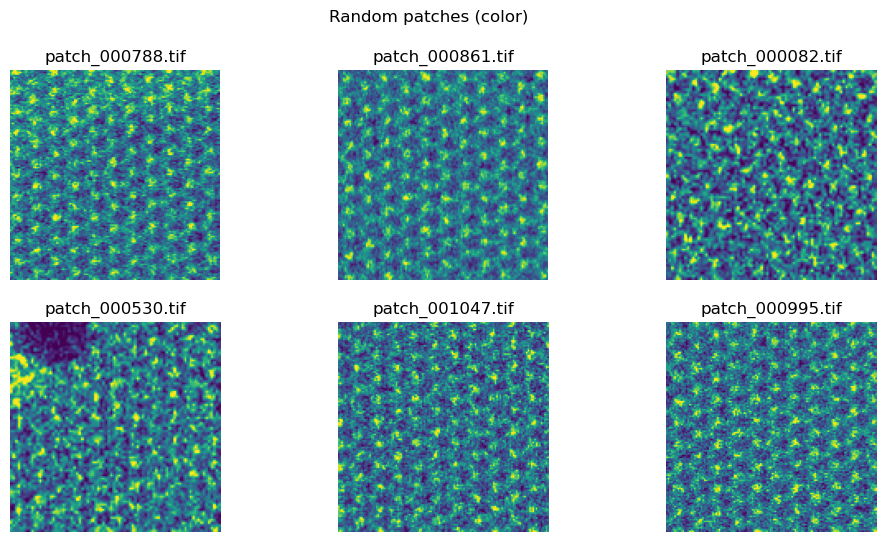

In [50]:
patches = sorted(PATCH_DIR.glob("*.tif"))
print(f"Found {len(patches)} patches in {PATCH_DIR}")
assert patches, "No patches found; run the generation step first."
rng = random.Random(0)
sel = rng.sample(patches, k=min(6, len(patches)))
imgs = [np.array(Image.open(p)) for p in sel]
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
for ax, img, p in zip(axes.flat, imgs, sel):
    ax.imshow(img, cmap="viridis", vmin=0, vmax=1)
    ax.set_title(p.name)
    ax.axis("off")
plt.suptitle("Random patches (color)")
plt.show()


## 3) Train SR3 diffusion
- Conditional SR3: input is concatenation of (noisy HR, upsampled LR).
- LR is made by blur → downsample (scale=2) → shot noise → Gaussian noise → clamp → upsample.
- Data range is `[-1, 1]` internally; TIFFs are stored as float in `[0, 1]`.
- Fewer DDPM steps (`--num-timesteps 400`) keep sampling fast. Increase if you want slightly smoother results.

Run inside `screen` if you want to let it finish in the background.

## 4) Visualize the latest triplet grid (LR | SR | HR)
This reads the most recent sample saved during training.

Showing epoch_050.png


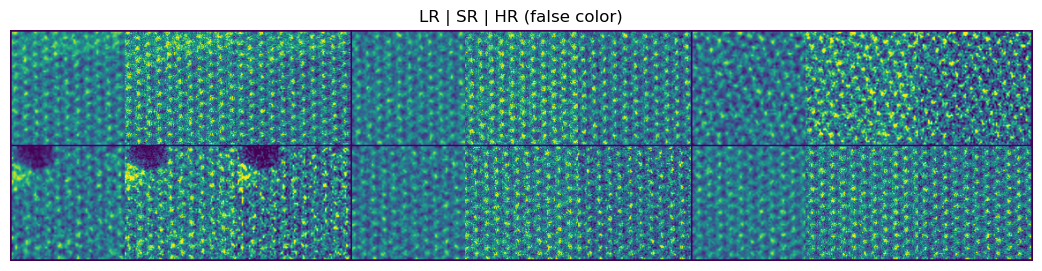

In [51]:
sample_dir = RUN_DIR / "samples"
latest = sorted(sample_dir.glob("epoch_*.png"))
if not latest:
    raise FileNotFoundError(f"No samples found in {sample_dir}. Run training or point RUN_NAME to an existing run.")
latest_img = np.array(Image.open(latest[-1])).astype(np.float32) / 255.0
print(f"Showing {latest[-1].name}")
plt.figure(figsize=(14, 3))
plt.imshow(latest_img, cmap="viridis")
plt.axis("off")
plt.title("LR | SR | HR (false color)")
plt.show()


## 5) Tips
- If LR looks too clean vs HR, **increase** `--shot-noise-scale` or `--gaussian-noise-std` a bit.
- If SR is grainy, try lowering `--shot-noise-scale` to 30–40 or reducing `--gaussian-noise-std-max` to 0.02.
- To monitor more often, set `--sample-every 20`. For shorter runs, reduce `--epochs` or `--target-train-size`.

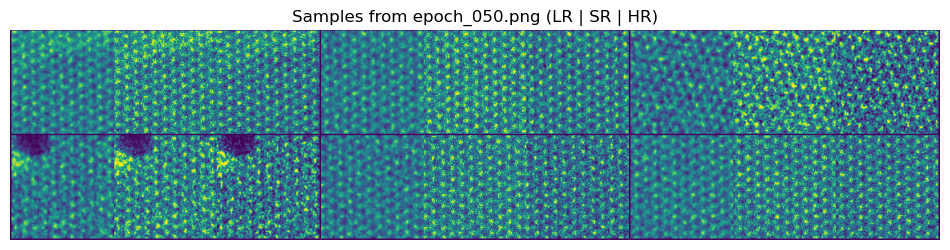

In [52]:

# Visualize latest saved triplets (LR | SR | HR) from disk
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

sample_dir = RUN_DIR / "samples"
latest = sorted(sample_dir.glob("epoch_*.png"))
if not latest:
    raise FileNotFoundError(f"No sample png found in {sample_dir}. Run training first.")
img = np.array(Image.open(latest[-1])).astype(np.float32) / 255.0
plt.figure(figsize=(12, 3))
plt.imshow(img, cmap="viridis", vmin=0, vmax=1)
plt.axis("off")
plt.title(f"Samples from {latest[-1].name} (LR | SR | HR)")
plt.show()
